# Matching FHDs to GLEAM data

In [4]:
import sys 
sys.path.append('/home/kelcey/hera/Washington/uwchamp2017/fits_functions')
sys.path.append('/home/kelcey/hera/Washington/uwchamp2017')

import clusterer as clst
import fits_functions as ff

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from astropy import units as u
import glob
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from pylab import *
from astropy.table import Table
from astropy.coordinates import match_coordinates_sky
from itertools import cycle

### Below cell configures the Matplotlib graphs to look nice

In [6]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')

### List of colors in Matplotlib to create random arrays of color.

In [7]:
cols = ['gray', 'silver', 'rosybrown', 'firebrick', 'red', 'darksalmon', 'sienna', 'sandybrown', 'tan', 
       'gold', 'darkkhaki', 'olivedrab', 'chartreuse', 'darkgreen', 'seagreen', 'mediumspringgreen',
       'lightseagreen', 'darkcyan', 'darkturquoise', 'deepskyblue', 'slategray', 'royalblue', 'navy', 
       'blue', 'mediumpurple', 'darkorchid', 'm', 'mediumvioletred', 'palevioletred', 'lightcoral', 
       'maroon', 'coral', 'peachpuff', 'darkorange', 'orange', 'darkgoldenrod', 'olive', 'yellowgreen',
       'lawngreen', 'lightgreen', 'g', 'mediumseagreen', 'darkslategrey', 'cadetblue', 'skyblue', 
       'dodgerblue']

### Below two functions are from clussterer.py and needed to be rewritten becasue the keywords did not match the keywords from the FHD files.

In [8]:
def separator_catalog(data):
    '''
    The separator splits all data which has been read in by the collector
    into individual lists for point sources and extended sources.
    
    This is primarily written to be used by the Seeker.
    
    Args:
        data: The variable assigned to the IDL .sav file which has been
            read in by the collector.

    Returns:
        data: A dictonary containing two keys:
            1. "extsources": The same data structure containing only extended sources.
            2. "psources": The same data structure containing only point sources.
    '''

    # A source is determined to be a point source if
    # it does not contain any extended components.
    point_data = [[data['data'][i]['catalog'][j]
                   for j in range(len(data['data'][i]['catalog']))
                  if data['data'][i]['catalog'][j]['EXTEND'] is None]
                  for i in range(len(data['data']))]

    # A source is determined to be an extended source if
    # it does contain any extended components.
    extended_data = [[data['data'][i]['catalog'][j]
                      for j in range(len(data['data'][i]['catalog']))
                      if data['data'][i]['catalog'][j]['EXTEND']
                      is not None]
                     for i in range(len(data['data']))]

    return {'extsources': extended_data, 'psources': point_data}

In [9]:
def seeker_catalog(data):
    """
    The seeker splits all data which has been read in by the collector
    into individual lists for RA, DEC, FLUX, XX, and YY values.
    Separate lists are made for point sources, extended sources,
    and all sources.
    
    Args:
        data: The variable assigned to the IDL .sav file which has been
            read in by the collector.

    Returns:
        Separated lists for ID, X, Y, RA, DEC, STON, FREQ, ALPHA, GAIN, FLAG,
        XX, YY, XY, YX, I, Q, U, and V values for point sources, extended sources,
        and all sources.
    """

    # Separating data into point sources and extended sources.
    separated = separator_catalog(data)

    # Creating individual lists for RA, DEC, FLUX, XX, and YY values
    # for point sources.
    point_sources_ID = [[separated['psources'][i][j]['ID']
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_X = [[separated['psources'][i][j]['X']
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_Y = [[separated['psources'][i][j]['Y']
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_RA = [[separated['psources'][i][j]['RA']
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_DEC = [[separated['psources'][i][j]['DEC']
                          for j in range(len(separated['psources'][i]))]
                         for i in range(len(separated['psources']))]
    point_sources_STON = [[separated['psources'][i][j]['STON']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_FREQ = [[separated['psources'][i][j]['FREQ']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_ALPHA = [[separated['psources'][i][j]['ALPHA']
                            for j in range(len(separated['psources'][i]))]
                           for i in range(len(separated['psources']))]
    point_sources_GAIN = [[separated['psources'][i][j]['GAIN']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_FLAG = [[separated['psources'][i][j]['FLAG']
                           for j in range(len(separated['psources'][i]))]
                          for i in range(len(separated['psources']))]
    point_sources_XX = [[separated['psources'][i][j]['FLUX']['XX'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_YY = [[separated['psources'][i][j]['FLUX']['YY'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_XY = [[separated['psources'][i][j]['FLUX']['XY'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_YX = [[separated['psources'][i][j]['FLUX']['YX'][0]
                         for j in range(len(separated['psources'][i]))]
                        for i in range(len(separated['psources']))]
    point_sources_I = [[separated['psources'][i][j]['FLUX']['I'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_Q = [[separated['psources'][i][j]['FLUX']['Q'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_U = [[separated['psources'][i][j]['FLUX']['U'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]
    point_sources_V = [[separated['psources'][i][j]['FLUX']['V'][0]
                        for j in range(len(separated['psources'][i]))]
                       for i in range(len(separated['psources']))]

    # Creating individual lists for RA, DEC, FLUX, XX, and YY values
    # for extended sources.
    EO_sources_ID = [[[separated['extsources'][i][j]['EXTEND']['ID'][k]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['ID']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_X = [[[separated['extsources'][i][j]['EXTEND']['X'][k]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['X']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_Y = [[[separated['extsources'][i][j]['EXTEND']['Y'][k]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['Y']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_RA = [[[separated['extsources'][i][j]['EXTEND']['RA'][k]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['RA']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_DEC = [[[separated['extsources'][i][j]['EXTEND']['DEC'][k]
                        for k in range(len(separated['extsources'][i][j]['EXTEND']['DEC']))]
                       for j in range(len(separated['extsources'][i]))]
                      for i in range(len(separated['extsources']))]
    EO_sources_STON = [[[separated['extsources'][i][j]['EXTEND']['STON'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['STON']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_FREQ = [[[separated['extsources'][i][j]['EXTEND']['FREQ'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['FREQ']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_ALPHA = [[[separated['extsources'][i][j]['EXTEND']['ALPHA'][k]
                          for k in range(len(separated['extsources'][i][j]['EXTEND']['ALPHA']))]
                         for j in range(len(separated['extsources'][i]))]
                        for i in range(len(separated['extsources']))]
    EO_sources_GAIN = [[[separated['extsources'][i][j]['EXTEND']['GAIN'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['GAIN']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_FLAG = [[[separated['extsources'][i][j]['EXTEND']['FLAG'][k]
                         for k in range(len(separated['extsources'][i][j]['EXTEND']['FLAG']))]
                        for j in range(len(separated['extsources'][i]))]
                       for i in range(len(separated['extsources']))]
    EO_sources_XX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XX'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_YY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YY'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_XY = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['XY'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_YX = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['YX'][0]
                       for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                      for j in range(len(separated['extsources'][i]))]
                     for i in range(len(separated['extsources']))]
    EO_sources_I = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['I'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_Q = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['Q'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_U = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['U'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]
    EO_sources_V = [[[separated['extsources'][i][j]['EXTEND']['FLUX'][k]['V'][0]
                      for k in range(len(separated['extsources'][i][j]['EXTEND']['FLUX']))]
                     for j in range(len(separated['extsources'][i]))]
                    for i in range(len(separated['extsources']))]

    # Fixing RA values to range between -180 and +180.
    for i in range(len(data['data'])):
        for j in range(len(EO_sources_RA[i])):
            for k in range(len(EO_sources_RA[i][j])):
                if EO_sources_RA[i][j][k] > 180:
                    EO_sources_RA[i][j][k] -= 360
        for j in range(len(point_sources_RA[i])):
            if point_sources_RA[i][j] > 180:
                point_sources_RA[i][j] -= 360

    # Adding point source and extended source lists to create
    # lists for RA, DEC, FLUX, XX, and YY values for all sources.
    all_RA = [[point_sources_RA[i][j]
               for j in range(len(point_sources_RA[i]))] +
              [EO_sources_RA[i][j][k]
              for j in range(len(EO_sources_RA[i]))
              for k in range(len(EO_sources_RA[i][j]))]
              for i in range(len(data['data']))]
    all_DEC = [[point_sources_DEC[i][j]
                for j in range(len(point_sources_DEC[i]))] +
               [EO_sources_DEC[i][j][k]
               for j in range(len(EO_sources_DEC[i]))
               for k in range(len(EO_sources_DEC[i][j]))]
               for i in range(len(data['data']))]
    all_I = [[point_sources_I[i][j]
              for j in range(len(point_sources_I[i]))] +
             [EO_sources_I[i][j][k]
             for j in range(len(EO_sources_I[i]))
             for k in range(len(EO_sources_I[i][j]))]
             for i in range(len(data['data']))]
    all_XX = [[point_sources_XX[i][j]
               for j in range(len(point_sources_XX[i]))] +
              [EO_sources_XX[i][j][k]
              for j in range(len(EO_sources_XX[i]))
              for k in range(len(EO_sources_XX[i][j]))]
              for i in range(len(data['data']))]
    all_YY = [[point_sources_YY[i][j]
               for j in range(len(point_sources_YY[i]))] +
              [EO_sources_YY[i][j][k]
              for j in range(len(EO_sources_YY[i]))
              for k in range(len(EO_sources_YY[i][j]))]
              for i in range(len(data['data']))]
    all_BEAM = [np.asarray(np.asarray(all_XX[i]) +
                np.asarray(all_YY[i])) / np.asarray(all_I[i])
                for i in range(len(data['data']))]

    return {'point_sources_ID': point_sources_ID,
            'point_sources_X': point_sources_X,
            'point_sources_Y': point_sources_Y,
            'point_sources_RA': point_sources_RA,
            'point_sources_DEC': point_sources_DEC,
            'point_sources_STON': point_sources_STON,
            'point_sources_FREQ': point_sources_FREQ,
            'point_sources_ALPHA': point_sources_ALPHA,
            'point_sources_GAIN': point_sources_GAIN,
            'point_sources_FLAG': point_sources_FLAG,
            'point_sources_XX': point_sources_XX,
            'point_sources_YY': point_sources_YY,
            'point_sources_XY': point_sources_XY,
            'point_sources_YX': point_sources_YX,
            'point_sources_I': point_sources_I,
            'point_sources_Q': point_sources_Q,
            'point_sources_U': point_sources_U,
            'point_sources_V': point_sources_V,
            'EO_sources_ID': EO_sources_ID,
            'EO_sources_X': EO_sources_X,
            'EO_sources_Y': EO_sources_Y,
            'EO_sources_RA': EO_sources_RA,
            'EO_sources_DEC': EO_sources_DEC,
            'EO_sources_STON': EO_sources_STON,
            'EO_sources_FREQ': EO_sources_FREQ,
            'EO_sources_ALPHA': EO_sources_ALPHA,
            'EO_sources_GAIN': EO_sources_GAIN,
            'EO_sources_FLAG': EO_sources_FLAG,
            'EO_sources_XX': EO_sources_XX,
            'EO_sources_YY': EO_sources_YY,
            'EO_sources_XY': EO_sources_XY,
            'EO_sources_YX': EO_sources_YX,
            'EO_sources_I': EO_sources_I,
            'EO_sources_Q': EO_sources_Q,
            'EO_sources_U': EO_sources_U,
            'EO_sources_V': EO_sources_V,
            'all_RA': all_RA, 'all_DEC': all_DEC, 'all_I': all_I,
            'all_XX': all_XX, 'all_YY': all_YY, 'all_BEAM': all_BEAM}

## Define the GLEAM catalog and import it so this does not have to be done inside afor loop. (This may take 5-10 minutes to run)

In [10]:
directory = '/home/kelcey/hera/Washington/uwashchamp2019/source_array_data/'
paths = glob.glob(directory + '*.sav')

In [11]:
GLEAM_path = '/home/kelcey/hera/Washington/GLEAM_v2_plus_rlb2019.sav'
GLEAM_data = clst.collector(GLEAM_path)
GLEAM_seek = seeker_catalog(GLEAM_data)
directory = '/home/kelcey/hera/Washington/uwashchamp2019/source_array_data/'

In [9]:
GLEAM_seek.keys()

['point_sources_DEC',
 'all_YY',
 'point_sources_YX',
 'EO_sources_Q',
 'point_sources_ID',
 'EO_sources_I',
 'point_sources_STON',
 'all_DEC',
 'EO_sources_DEC',
 'EO_sources_FREQ',
 'EO_sources_YX',
 'EO_sources_YY',
 'all_BEAM',
 'all_I',
 'point_sources_RA',
 'all_XX',
 'EO_sources_ALPHA',
 'point_sources_V',
 'point_sources_U',
 'EO_sources_FLAG',
 'EO_sources_XX',
 'EO_sources_X',
 'point_sources_Q',
 'point_sources_ALPHA',
 'point_sources_XX',
 'point_sources_XY',
 'point_sources_YY',
 'point_sources_GAIN',
 'EO_sources_RA',
 'point_sources_Y',
 'point_sources_X',
 'EO_sources_V',
 'point_sources_FREQ',
 'all_RA',
 'EO_sources_Y',
 'EO_sources_ID',
 'EO_sources_GAIN',
 'EO_sources_U',
 'point_sources_FLAG',
 'EO_sources_XY',
 'point_sources_I',
 'EO_sources_STON']

## Matching the FHDs to GLEAM:

This is a step-by-step walk through of the below function. The function should return some important information that will help identify sources across observations.

* Inputs: the function will require two inputs when called. The first input is an absolute path to 

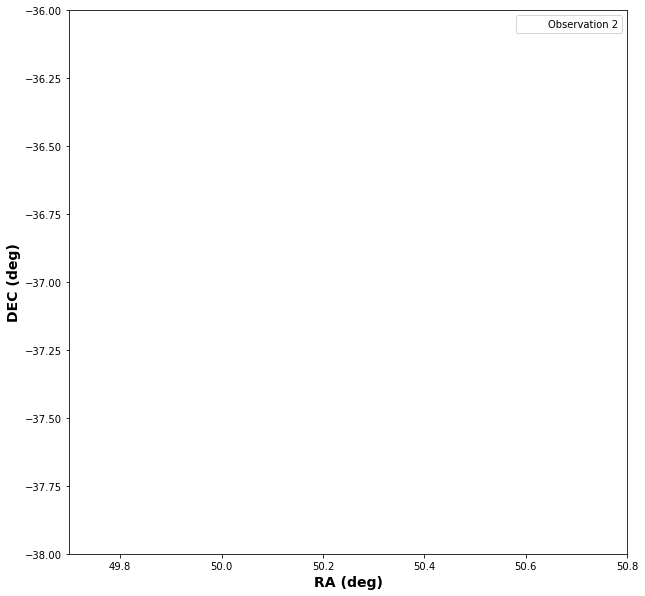

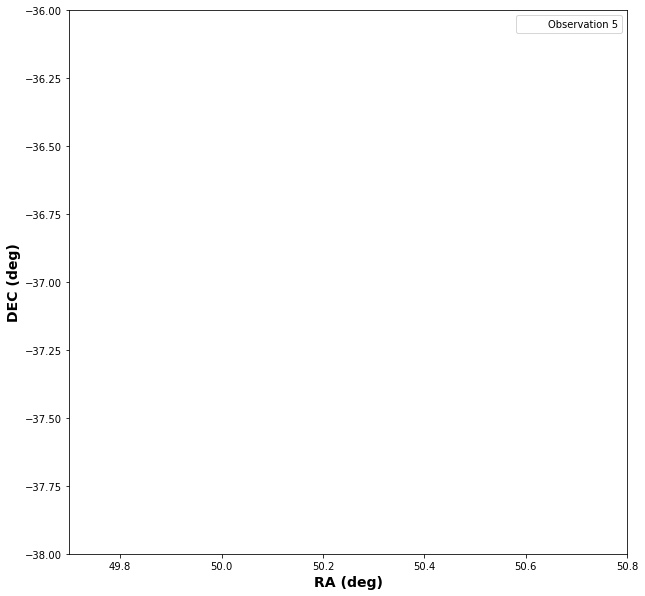

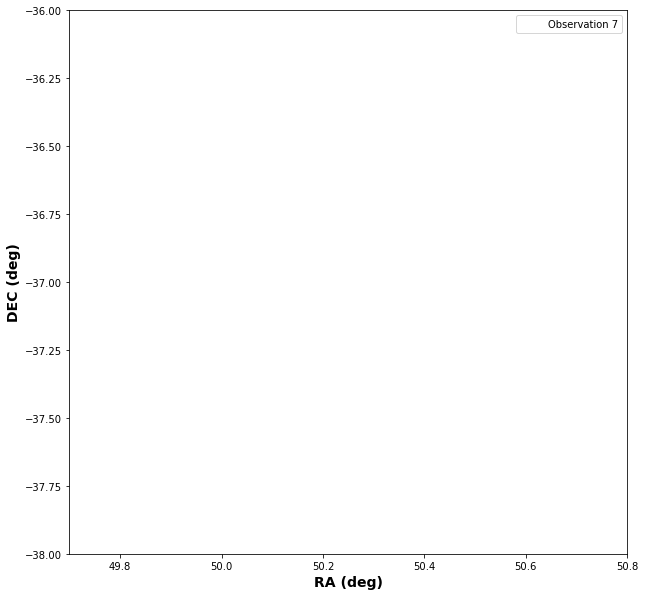

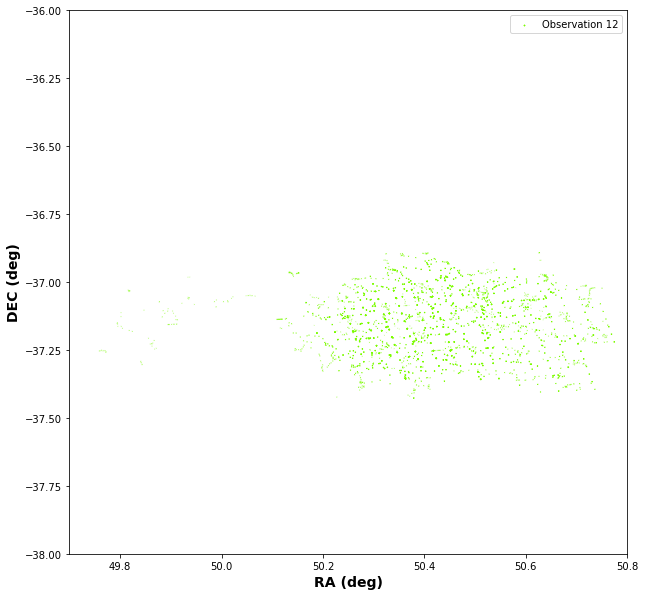

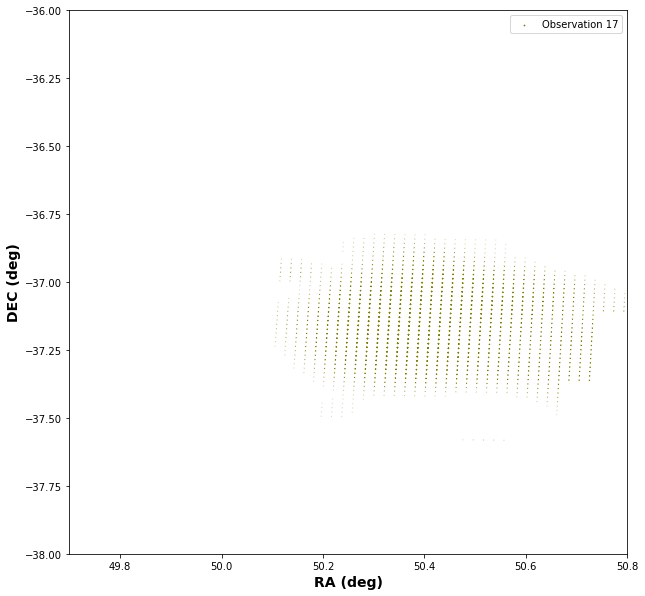

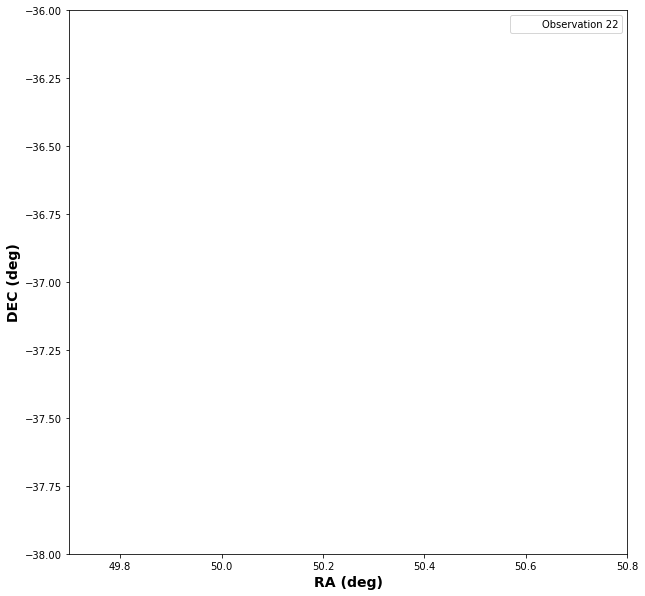

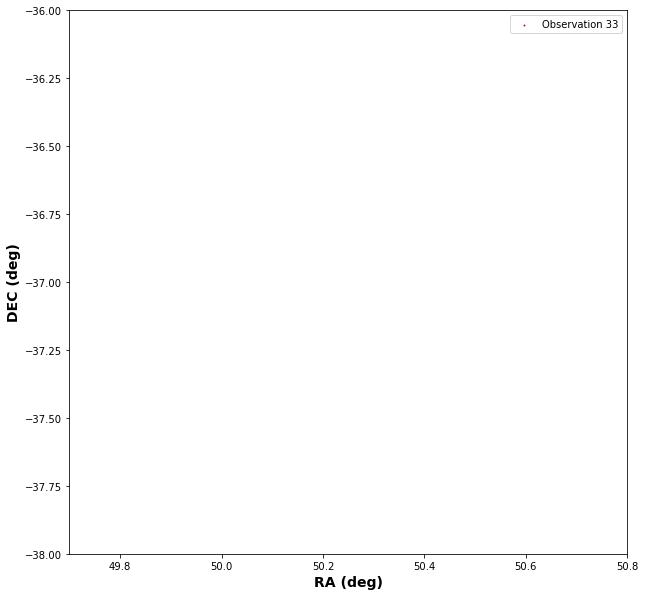

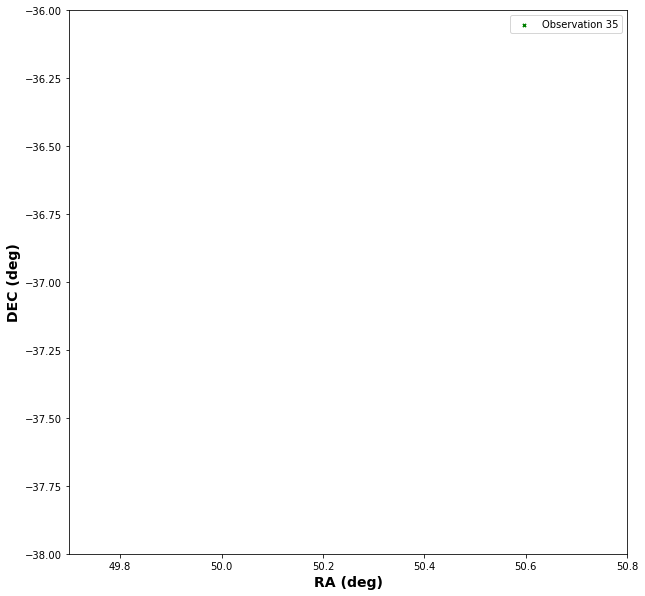

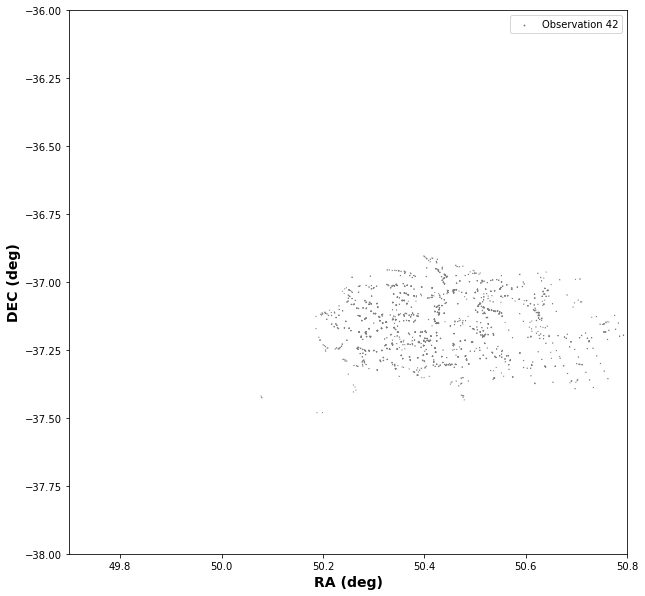

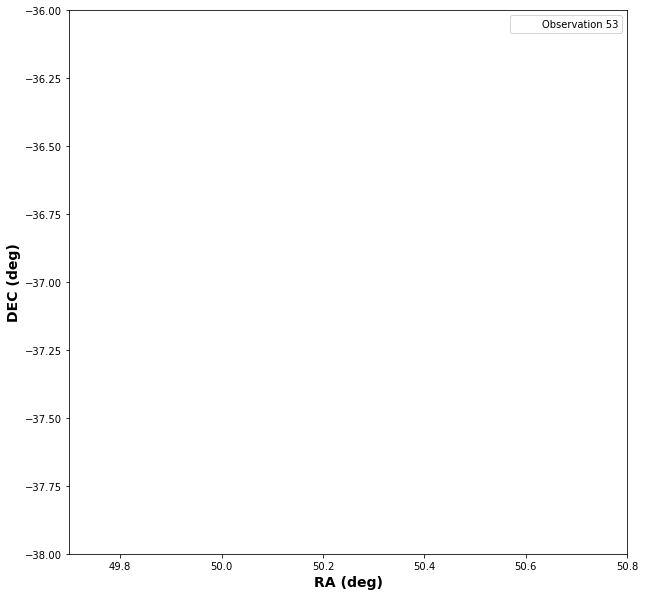

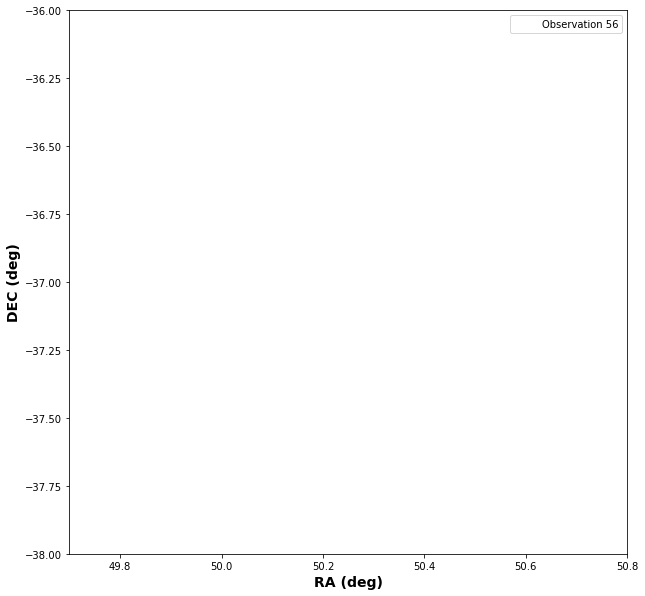

In [124]:
#mags = match_data.loc[i]
 
eo_ras = match_data.loc[115080][0::5][1:]
eo_decs = match_data.loc[115080][1::5][1:]
eo_mags = match_data.loc[115080][2::5][1:]
mags = match_data.loc[115080][3::5]
colors = np.random.choice(cols, len(eo_ras))
n = 0
for i in range(0, len(mags)):
    n = n+1
    if mags[i] != 0:
        plt.figure()
        plt.scatter(eo_ras[i], eo_decs[i],marker = 'x', color = colors[i], s = eo_mags[i],
                    label = 'Observation {}'.format(n))
        plt.xlim(49.7, 50.8)
        plt.ylim(-38, -36)
        plt.xlabel('RA (deg)')
        plt.ylabel('DEC (deg)')
        plt.legend();

In [12]:
def match_to_gleam(directory, GLEAM_seek):
    """
    Matches all the .sav files in a given directory with GLEAM
    
    directory is an absolute path to the data
    
    GLEAM_seek is the GLEAM catalog after being run through the corrected seeker function
    
    """
    #Create paths to all the .sav files in the specified directory
    paths = glob.glob(directory + '*.sav')
    
    #Load the GLEAM data
    ra_gleam = np.array(GLEAM_seek['point_sources_RA'][0])
    dec_gleam = np.array(GLEAM_seek['point_sources_DEC'][0])
    imag_gleam = np.array(GLEAM_seek['point_sources_I'][0])
    
    #Create a Pandas Data Frame with the RA, DEC, and GLEAM Magnitudes
    n=0
    df = pd.DataFrame({'RA': ra_gleam,'Mag GLEAM': imag_gleam,  'DEC' : dec_gleam})
    
    #Look at each path in the directory
    #WARNING: 2 files takes 15-20 minutes to load. DO NOT change the indecies unless 
    #you are prepared to wait a while. There are over 300k stars in GLEAM
    for path in paths[0:15]:
        
        #Collect the data for each path
        n = n + 1
        data = clst.collector(path)
        data_seek = clst.seeker(data)
        #imag = np.array(data_seek['point_sources_I'][0])
        
        eo = []
        eo_ra = []
        eo_dec = []
        ps_RA = []
        ps_DEC = []
        i_mag = []
        EO_imag = []

        data = clst.collector(path)
        d_s = data['data'][0]['source_array']
     
        for d in d_s:
            if d['EXTEND'] is None:
                ps_RA.append(d['RA'])
                ps_DEC.append(d['DEC'])
                EO_imag.append(0)
                eo_ra.append(0)
                eo_dec.append(0)
                i_mag.append(d['FLUX']['I'])
                
            else:
                ps_RA.append(d['RA'])
                ps_DEC.append(d['DEC'])
                EOmags = []
                for i in range(0, d['EXTEND'][0]['FLUX'].shape[0]):
                    EOmags.append(d['EXTEND'][0]['FLUX'][i]['I'])
                EO_imag.append(np.array(EOmags))
                eo_ra.append(d['EXTEND']['RA'])
                eo_dec.append(d['EXTEND']['DEC'])
                i_mag.append(d['FLUX']['I'])
        #Match this path with the GLEAM catalog
        #idx: an array of indices corresponding to matches
        #d2d: the two dimensional distances between these matches
        #d3d: three dimensional distances between matches. This array is blank becasue we do 
        #not have 3 dimensional data, but the match_to_catalog_sky function requires it anyway
        catalog = SkyCoord(ra=ps_RA*u.deg, dec=ps_DEC*u.deg)  
        c = SkyCoord(ra=ra_gleam*u.deg, dec=dec_gleam*u.deg)  
        idx, d2d, d3d = c.match_to_catalog_sky(catalog)  
        
        
        #Possible source of error because the below statement is worded a little strange
        #Only return matches within one degree 
        mags = []
        imags = np.array(i_mag)[idx]
        nums = np.arange(0, len(idx))
        for num in nums:
            if (d2d[num] < (0.05*u.deg)) and ((imags[num] > imag_gleam[num] + (3/4)*imag_gleam[num]) or (imags[num] > (3/4)*imag_gleam[num])):
                mags.append(imags[num])
            else: 
                mags.append(0)
                

      
        #Add a new column to the data frame with the information from this path      
        s_mag = pd.Series(mags)
        s_dist = pd.Series(d2d)
        df['Mag {}'.format(n)] = s_mag
        df['Distance {}'.format(n)] = s_dist
        
        df['RA {}'.format(n)] = np.array(ps_RA)[idx]
        df['DEC {}'.format(n)] = np.array(ps_DEC)[idx]
        df['EO RA {}'.format(n)] = np.array(eo_ra)[idx]
        df['EO DEC {}'.format(n)] = np.array(eo_dec)[idx]
        df['EO Mag {}'.format(n)] = np.array(EO_imag)[idx]
        
    return df

In [13]:
directory = '/home/kelcey/hera/Washington/uwashchamp2019/source_array_data/'
table = match_to_gleam(directory, GLEAM_seek)
table

,DEC,Mag GLEAM,RA,Mag 1,Distance 1,RA 1,DEC 1,EO RA 1,EO DEC 1,EO Mag 1,...,EO RA 14,EO DEC 14,EO Mag 14,Mag 15,Distance 15,RA 15,DEC 15,EO RA 15,EO DEC 15,EO Mag 15
0,-89.687309,0.303373,-2.085632,0,2.719350,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,2.719356,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
1,-89.213310,0.227618,-21.663757,0,2.464659,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,2.464665,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
2,-89.155968,0.451251,-11.600952,0,2.598894,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,2.598900,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
3,-88.750610,1.528642,-14.703156,0,2.551081,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,2.551086,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
4,-88.740990,0.290795,-41.215271,0,1.983217,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,1.983222,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
5,-88.825325,0.315769,-10.407288,0,2.634402,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,2.634407,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
6,-88.430840,0.253299,-8.097626,0,2.769716,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,2.769721,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
7,-88.290367,0.113284,-24.161621,0,2.348060,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,2.348064,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
8,-88.139534,0.416708,-15.071472,0,2.655384,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,2.655387,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]
9,-88.058319,0.426634,-0.703857,0,3.124142,277.911987,-87.243843,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417],...,"[10.893348, 10.821323, 10.787983]","[-48.780964, -48.7885, -48.8442]",[0.3030609],0,3.124146,277.912048,-87.243835,"[277.66492, 278.78635]","[-87.23019, -87.29068]",[0.84616417]


In [15]:
mgs= np.array(table['Mag 1'])
i = mgs>15
table.loc[i]

,DEC,Mag GLEAM,RA,Mag 1,Distance 1,RA 1,DEC 1,EO RA 1,EO DEC 1,EO Mag 1,...,EO RA 14,EO DEC 14,EO Mag 14,Mag 15,Distance 15,RA 15,DEC 15,EO RA 15,EO DEC 15,EO Mag 15
50185,-65.749672,50.042076,62.085506,[57.923397],0.016273,62.125034,-65.748558,"[62.11835, 62.118904, 62.119617, 62.119995, 62...","[-65.749275, -65.74922, -65.74915, -65.74907, ...",[4.9555755],...,"[16.637352, 16.503155]","[-46.649235, -46.67434]",[0.40759805],[60.512405],0.012278,62.114151,-65.753189,0,0,0
53261,-62.393787,16.335974,65.233665,[19.362183],0.012430,65.257660,-62.388233,0,0,0,...,"[16.637352, 16.503155]","[-46.649235, -46.67434]",[0.40759805],[20.767792],0.010294,65.255844,-62.393211,0,0,0
57901,-54.542625,15.938519,96.694405,[20.261127],0.018197,96.698441,-54.524578,"[96.72104, 96.721405, 96.72176, 96.72217, 96.7...","[-54.525074, -54.52534, -54.525654, -54.5261, ...",[1.1417831],...,"[19.686172, 19.599386]","[-44.512188, -44.538]",[0.49776146],0,3.345949,90.929916,-54.483875,"[90.94386, 90.84864]","[-54.48891, -54.4545]",[0.73233914]
58381,-53.690434,37.654785,96.594780,[36.36078],0.023169,96.625679,-53.676224,0,0,0,...,"[19.686172, 19.599386]","[-44.512188, -44.538]",[0.49776146],0,3.415131,90.929916,-54.483875,"[90.94386, 90.84864]","[-54.48891, -54.4545]",[0.73233914]
63463,-53.822166,14.621412,67.279350,[23.422552],0.019354,67.246582,-53.822838,"[67.26982, 67.2697, 67.26958, 67.269424, 67.26...","[-53.819984, -53.81985, -53.819717, -53.81959,...",[1.1199137],...,"[19.686172, 19.599386]","[-44.512188, -44.538]",[0.49776146],[23.6062],0.021308,67.244110,-53.826790,"[67.26811, 67.26808, 67.26805, 67.26803, 67.26...","[-53.8207, -53.820667, -53.820637, -53.820602,...",[1.1619396]
68949,-48.399612,14.401370,78.212357,[18.498484],0.006260,78.221687,-48.398720,"[78.21951, 78.219536, 78.21956, 78.21958, 78.2...","[-48.396076, -48.396084, -48.396088, -48.39610...",[1.2280071],...,"[19.686172, 19.599386]","[-44.512188, -44.538]",[0.49776146],[18.747086],0.007056,78.222878,-48.400616,"[78.22137, 78.22129, 78.221214, 78.22112, 78.2...","[-48.40033, -48.40011, -48.3999, -48.399666, -...",[1.2531079]
75219,-45.172649,12.953273,50.347630,[15.643873],0.012203,50.335800,-45.181561,"[50.351448, 50.35148, 50.351566, 50.351578, 50...","[-45.173496, -45.173378, -45.173172, -45.17312...",[0.7375405],...,"[19.686172, 19.599386]","[-44.512188, -44.538]",[0.49776146],[16.11429],0.020913,50.323662,-45.184975,"[50.338226, 50.338318, 50.33845, 50.338547, 50...","[-45.171257, -45.171284, -45.1713, -45.171288,...",[0.7562071]
86043,-36.457577,49.942623,80.741081,[51.071712],0.014280,80.751289,-36.445892,0,0,0,...,"[19.686172, 19.599386]","[-44.512188, -44.538]",[0.49776146],[50.44239],0.015232,80.752647,-36.445515,"[80.757324, 80.75723, 80.75712, 80.75702, 80.7...","[-36.44548, -36.44568, -36.445778, -36.4459, -...",[4.066289]
88048,-36.514114,14.727457,67.420143,[16.088371],0.009872,67.425400,-36.505188,0,0,0,...,"[27.056738, 27.114391, 26.979216]","[-25.315184, -25.302101, -25.306911]",[0.07280188],[16.04844],0.007389,67.422455,-36.506962,0,0,0


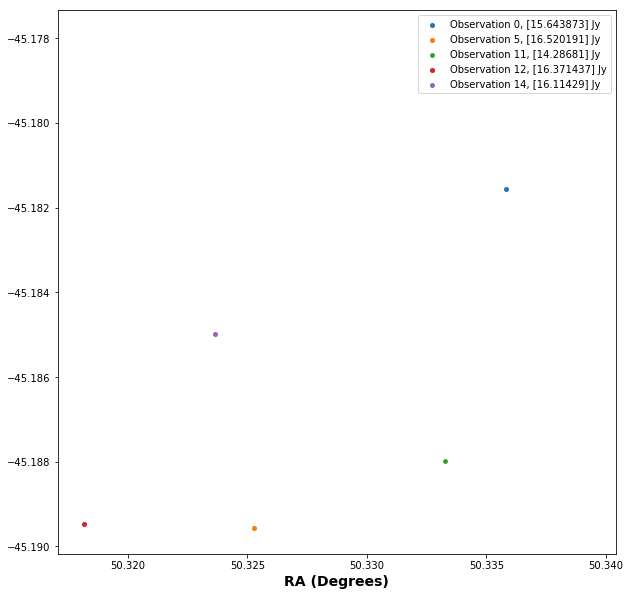

In [32]:
mags = table.loc[75219][3::7]
ras = table.loc[75219][5::7]
decs = table.loc[75219][6::7]
mag_change = []
for i in range(0, len(mags)):
    if mags[i] !=0:
        mag_change.append(mags[i])
        plt.scatter(ras[i], decs[i], s = mags[i], label = 'Observation {}, {} Jy'.format(i, mags[i]))
        plt.xlabel('RA (Degrees)')
        plt.ylabel = ('DEC (Degrees)')
        plt.legend();

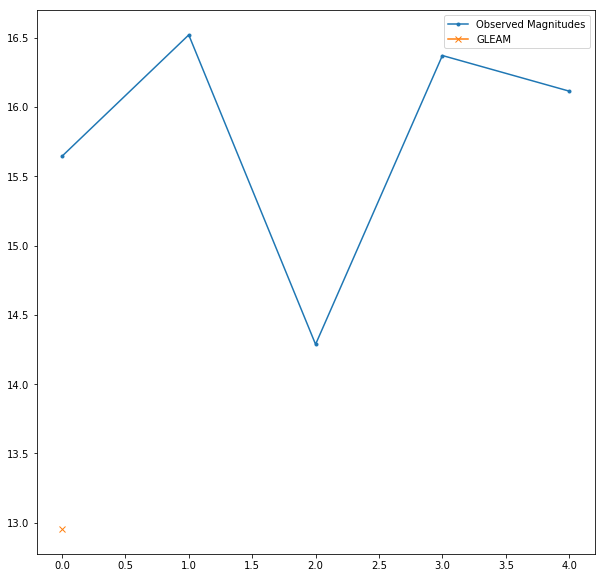

In [40]:
plt.plot(mag_change, marker = '.', label = 'Observed Magnitudes')
plt.plot(table.loc[75219]['Mag GLEAM'], label = 'GLEAM', marker = 'x')
#plt.ylabel('y')
plt.legend();

In [42]:
table.loc[53261]

DEC                                                     -62.3938
Mag GLEAM                                                 16.336
RA                                                       65.2337
Mag 1                                                [19.362183]
Distance 1                                               0.01243
RA 1                                                     65.2577
DEC 1                                                   -62.3882
EO RA 1                                                        0
EO DEC 1                                                       0
EO Mag 1                                                       0
Mag 2                                                          0
Distance 2                                               17.8184
RA 2                                                     48.5468
DEC 2                                                   -47.2509
EO RA 2                                     [48.5322, 48.596653]
EO DEC 2                 

In [ ]:
mgs= np.array(table['Mag 1'])
i = mgs>15
table.loc[i]